In [14]:
import torch
import wandb
import torch.optim as optim
from utils.wandb import wandb_init
from train_rq_vae import train
from omegaconf import OmegaConf
from plotting.plot import plot_results_panels
from data.loader import load_movie_lens
from modules.rq_vae import RQ_VAE
from utils.model_id_generation import generate_model_id

In [ ]:
cfg = OmegaConf.load('config/config_ml1m.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb_init(cfg)

data = load_movie_lens(
    file_path='dataset/ml-1m/ml-1m.inter',
    normalize_data=cfg.data.normalize_data,
    train=True)
print(data.shape)

model = RQ_VAE(
        input_dim = data.shape[1],
        latent_dim = cfg.model.latent_dimension,
        hidden_dims = cfg.model.hidden_dimensions,
        codebook_size = cfg.model.codebook_clusters,
        codebook_kmeans_init = True,
        codebook_sim_vq = True,
        n_quantization_layers = cfg.model.num_codebook_layers,
        commitment_weight = cfg.model.commitment_weight,
)
model.to(device)

wandb.watch(model)

optimizer = optim.AdamW(model.parameters(), lr=cfg.train.learning_rate, weight_decay=cfg.train.weight_decay)

In [ ]:
losses = train(model, data, optimizer, cfg.train.num_epochs, device, cfg)

if cfg.general.save_model:
    model_id = generate_model_id(cfg)
    print(f"Model ID: {model_id}")
    torch.save(model.state_dict(), f"models/{model_id}.pth")
    
#model.load_state_dict(torch.load("models/amazon-beauty-bs256-normF-hd768_512_256-ld256-cb3x256-cw0.25-lr0.001-wd0.0001-ep200.pth"))
wandb.finish()

Training Loop: 100%|██████████| 256/256 [01:44<00:00,  2.44it/s, Epoch=255, Loss=2.21e+6, Reconstruction Loss=2.2e+6, RQ-VAE Loss=1.51e+4, Prob Unique IDs=0.999] 


Model ID: ml-bs1024-normF-hd3706_1024_512-ld256-cb3x256-cw0.25-lr0.001-wd0.0001-ep256


Epoch,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Prob Unique IDs,▁▁▁▁▁▁▁▂▂▂▄▅▅▆▇█████████████████████████
RQ-VAE Loss,▁▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reconstruction Loss,████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▁▂▂▁▁
Epoch,255
Loss,2210313.35
Prob Unique IDs,0.99902
RQ-VAE Loss,15123.28086
Reconstruction Loss,2195190.0


In [ ]:
model.get_semantic_ids(data.to(device)).sem_ids

tensor([[ 46,  30, 130],
        [ 33, 239, 192],
        [ 89, 222,  45],
        ...,
        [ 48, 172, 111],
        [ 64, 107,  89],
        [ 40,  21, 212]], device='cuda:0')

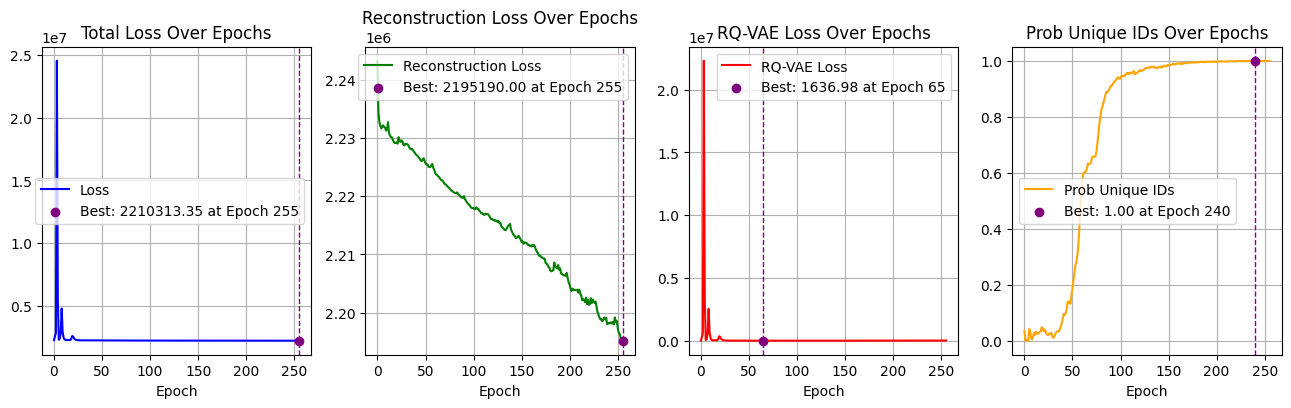

In [ ]:
# Plot configuration
plot_configs = [
    ('Loss', 'Total Loss Over Epochs', 'blue', 'low'),
    ('Reconstruction Loss', 'Reconstruction Loss Over Epochs', 'green', 'low'),
    ("RQ-VAE Loss", 'RQ-VAE Loss Over Epochs', 'red', 'low'),
    ('Prob Unique IDs', 'Prob Unique IDs Over Epochs', 'orange', 'high'),
]

model_id = generate_model_id(cfg)
fig = plot_results_panels(losses, plot_configs)
fig.savefig(f"outputs/plots/{model_id}.png", dpi=600, bbox_inches='tight')